# Depth Estimation with Masked Image Modeling

This notebook will show monocular depth estimation for robotic applications.
The used model is taken from [this](https://github.com/SwinTransformer/MIM-Depth-Estimation/tree/main) repository for the paper ["Revealing the Dark Secrets of Masked Image Modeling (Depth Estimation)"](https://arxiv.org/abs/2205.13543).

## Setup

### Standard imports

In [1]:
#std libs
from collections import OrderedDict

#non std libs
import torch
from torchvision.transforms import ToTensor
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Import of the model

In [2]:
from models.model import GLPDepth

/mnt/Daten2/Uni/Projekt_BCV/monocular_depth_estimation/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Specification of parameters

Name           | Type   | Value
---------------|--------|----------------------------------------------------------------------------------------------------------------------------------------------
`USE_NYU`      | `bool` | `True`: Use the weights pretrained on "nyudepthv2"<br>`False`: Use the weights pretrained on the kitti eigen split
`INPUT_IMAGE`  | `str`  | The path to the input image.
`CROP_TO_SIZE` | `bool` | `True`: Crop the image to size (1216, 352). This loses parts of the image completely.<br>`False`: Resize the image. This distortes the image.

In [3]:
USE_NYU     = True;
INPUT_IMAGE = "normal.png"
CROP_TO_SIZE= False;

### Automatic device detection and setup

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda");
    device_prop = torch.cuda.get_device_properties(device);
    print(f"Using GPU: {device_prop.name} {round(device_prop.total_memory / 1024**3, 2)}GiB (CC: {device_prop.major}.{device_prop.minor})");
else:
    device = torch.device("cpu");
    print("Using CPU.");
torch.set_default_device(device);

Using GPU: NVIDIA GeForce RTX 2070 7.79GiB (CC: 7.5)


In [5]:
class Storage:
    #a minimal storage class to somewhat mimic the behaviour of argparse.ArgumentParser
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs);

## Model setup 

### Default command for kitti setup

```bash
python3 test.py \
--dataset kitti \
--kitti_crop garg_crop \
--data_path ../data/ \
--max_depth 80.0 \
--max_depth_eval 80.0 \
--backbone swin_large_v2 \
--depths 2 2 18 2 \
--num_filters 32 32 32 \
--deconv_kernels 2 2 2 \
--window_size 22 22 22 11 \
--pretrain_window_size 12 12 12 6 \
--use_shift True True False False \
--flip_test \
--shift_window_test \
--shift_size 16 \
--do_evaluate \
--ckpt_dir ckpt/kitti_swin_large.ckpt
```

In [6]:
kitti_args = Storage(
    max_depth=80.0,
    backbone="swin_large_v2",
    depths=[2, 2, 18, 2],
    window_size=[22, 22, 22, 11],
    pretrain_window_size=[12, 12, 12, 6],
    drop_path_rate=0.3, #
    use_checkpoint=False, #
    use_shift=[True, True, False, False],
    pretrained='', #
    num_deconv=3, #
    num_filters=[32, 32, 32],
    deconv_kernels=[2, 2, 2],
)

### Default command for nyudepth setup

```bash
python3 test.py \
--dataset nyudepthv2 \
--data_path ../data/ \
--max_depth 10.0 \
--max_depth_eval 10.0  \
--backbone swin_large_v2 \
--depths 2 2 18 2 \
--num_filters 32 32 32 \
--deconv_kernels 2 2 2 \
--window_size 30 30 30 15 \
--pretrain_window_size 12 12 12 6 \
--use_shift True True False False \
--flip_test \
--shift_window_test \
--shift_size 2 \
--do_evaluate \
--ckpt_dir ckpt/nyudepthv2_swin_large.ckpt
```

In [7]:
nyudepthv2_args = Storage(
    max_depth=10.0,
    backbone="swin_large_v2",
    depths=[2, 2, 18, 2],
    window_size=[30, 30, 30, 15],
    pretrain_window_size=[12, 12, 12, 6],
    drop_path_rate=0.3, #
    use_checkpoint=False, #
    use_shift=[True, True, False, False],
    pretrained='', #
    num_deconv=3, #
    num_filters=[32, 32, 32],
    deconv_kernels=[2, 2, 2],
)

### Instanciate model and load weights

In [8]:
if USE_NYU:
    print("Using weights pretrained on nyudepthv2.")
    model = GLPDepth(args=nyudepthv2_args);

    model_weights: dict = torch.load("./checkpoints/nyudepthv2_swin_large.ckpt", map_location=device);
else:
    print("Using weights pretrained on kitti.")
    model = GLPDepth(args=kitti_args);

    model_weights: dict = torch.load("./checkpoints/kitti_swin_large.ckpt", map_location=device);

model = model.to(device);

if 'module' in next(iter(model_weights.items()))[0]:
    model_weight = OrderedDict((k[7:], v) for k, v in model_weights.items())

model.load_state_dict(model_weights);
model.eval();

Using weights pretrained on nyudepthv2.


/mnt/Daten2/Uni/Projekt_BCV/monocular_depth_estimation/venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(30, 30)] ==> [12]
norm8_log_bylayer: [(15, 15)] ==> [6]
norm8_log_bylayer: [(15, 15)] ==> [6]


### Load and prepare the image

In [9]:
img = cv.imread(INPUT_IMAGE);
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

In [10]:
if CROP_TO_SIZE:
    h_im, w_im = img.shape[:2]

    margin_top = int(h_im - 352)
    margin_left = int((w_im - 1216) / 2)

    sized_image = img[margin_top:  margin_top  + 352,
              margin_left: margin_left + 1216]
else:
    sized_image = cv.resize(img, (1216, 352));

In [11]:
img_tensor = ToTensor()(sized_image)
img_tensor = img_tensor[None, :, :, :]
img_tensor = img_tensor.to(device);

### Predict the depth map

In [12]:
with torch.no_grad():
    prediction = model(img_tensor);

In [13]:
pred_tensor: torch.Tensor = prediction["pred_d"]

### Convert the prediction into a user readable output

In [14]:
pred_tensor_numpy: np.ndarray = pred_tensor.squeeze().cpu().numpy()
pred_tensor_numpy = (pred_tensor_numpy / pred_tensor_numpy.max()) * 255
pred_tensor_numpy = pred_tensor_numpy.astype(np.uint8)
pred_tensor_numpy = cv.applyColorMap(255 - pred_tensor_numpy, cv.COLORMAP_DEEPGREEN);

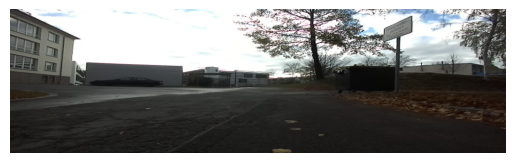

In [15]:
plt.imshow(sized_image);
plt.axis("off");

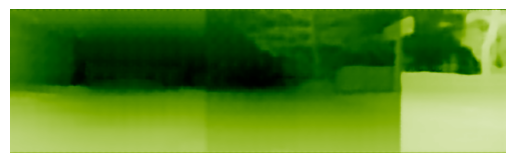

In [16]:
plt.imshow(pred_tensor_numpy);# cmap="plasma");
plt.axis("off");

In [17]:
if not cv.imwrite("result.png", pred_tensor_numpy):
    print("Unable to save result image.");
if not cv.imwrite("original.png", sized_image):
    print("Unable to save original image.");